Optimisation project by Håvard Fossdal, Henning Hegstad, Eivind Jensløkken and Elias Solberg Ovesen.

This code has taken ispiraton from "LineSearchMethods.py" by Markus Grasmair.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class Initialization(object): 
    def __init__(self, E_tot,e_cable,e_bar,k,c,mg,gRho,N,M):
        self.E_tot = E_tot
        self.e_cable = e_cable
        self.e_bar = e_bar
        self.k = k
        self.c = c
        self.mg = mg
        self.gRho = gRho
        self.N = N
        self.M = M

In [3]:
def gradient(X,obj):
    e_cable = obj.e_cable
    e_bar = obj.e_bar
    N = obj.N
    M = obj.M
    c = obj.c
    k = obj.k
    mg = obj.mg
    gRho = obj.gRho
   
    grad = np.zeros(3*N)

    #tensegrity of cables
    for i in range(M,N):
        grad[3*i+2] += mg[i]
        for j in range(N):
            if e_cable[i,j] > 0:
                norm = np.linalg.norm(X[i]-X[j])
                l = e_cable[i,j]
                if norm > l:
                    
                    grad[3*i]     += k/l**2*(norm - l)*(X[i,0]-X[j,0])/norm
                    grad[3*i + 1] += k/l**2*(norm - l)*(X[i,1]-X[j,1])/norm
                    grad[3*i + 2] += k/l**2*(norm - l)*(X[i,2]-X[j,2])/norm
                    
    #tensegrity of bars
    for i in range(M,N):
        for j in range(N):
            l = e_bar[i,j]
            if l > 0:
                norm = np.linalg.norm(X[i]-X[j])

                grad[3*i]     += c/l**2*(norm - l)*(X[i,0]-X[j,0])/norm
                grad[3*i + 1] += c/l**2*(norm - l)*(X[i,1]-X[j,1])/norm
                grad[3*i + 2] += c/l**2*(norm - l)*(X[i,2]-X[j,2])/norm

    #gravity of bars
    for i in range(M,N):
        for j in range(N):
            l = e_bar[i,j]
            if l > 0:
                grad[3*i + 2] += gRho*l/2

    return grad.reshape(N, 3)


In [4]:
def E_cable(X, obj):
    e = obj.e_cable
    k = obj.k
    mg = obj.mg
    M = obj.M
    N = obj.N

    E_tot = 0
    for i in range(N):
        for j in range(i+1,N):
            if e[i,j] > 0:
                norm = np.linalg.norm(X[i]-X[j])
                l = e[i,j]
                if norm > l:
                    E_tot += k/(2*l**2) * (norm - l)**2
    
    return E_tot

In [5]:
def E_bar_elast(X,obj):
    e = obj.e_bar
    mg = obj.mg
    M = obj.M
    N = obj.N
    c = obj.c

    E_tot = 0
    for i in range(N):
        for j in range(i+1,N):
            l = e[i,j]
            if l > 0:
                norm = np.linalg.norm(X[i]-X[j])
                E_tot += c/(2*l**2) * (norm - l)**2
    
    return E_tot

In [6]:
def E_bar_grav(X,obj):
    e = obj.e_bar
    k = obj.k
    mg = obj.mg
    M = obj.M
    N = obj.N
    gRho = obj.gRho
    E_tot = 0
    for i in range(N):
        for j in range(i+1,N):
            l = e[i,j]
            if l > 0:
                E_tot += gRho*l/2*(X[i,2]+X[j,2])

    return E_tot

In [7]:
def E_ext(X,obj):
    mg = obj.mg
    N = obj.N

    E_tot = 0
    for i in range(N):
        E_tot += X[i,2]*mg[i] # Adding external force
    return E_tot

In [8]:
def E_tot(X,obj):
    return E_cable(X,obj) + E_bar_elast(X,obj) + E_bar_grav(X,obj) + E_ext(X,obj)

In [9]:
def plot_cables_bars(X,e_cable,e_bar,savefigure = "",ground=False):

    x_coords = X[:, 0]
    y_coords = X[:, 1]
    z_coords = X[:, 2]

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot points
    ax.scatter(x_coords, y_coords, z_coords, c='r', marker='o')

    # Plot lines for cables
    for i in range(e_cable.shape[0]):
        for j in range(i+1, e_cable.shape[1]):
            if e_cable[i, j] > 0:
                x = [x_coords[i], x_coords[j]]
                y = [y_coords[i], y_coords[j]]
                z = [z_coords[i], z_coords[j]]
                ax.plot(x, y, z, '--', color='cornflowerblue')
            if e_bar[i,j] > 0:
                x = [x_coords[i], x_coords[j]]
                y = [y_coords[i], y_coords[j]]
                z = [z_coords[i], z_coords[j]]
                ax.plot(x, y, z, c='green') 
   
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(15,20)
    # ax.view_init(5)

    if ground == True:
        x_min = min(x_coords)
        x_max = max(x_coords)
        y_min = min(y_coords)
        y_max = max(y_coords)
        length_min = min(x_min,y_min) 
        length_max = max(x_max,y_max)
        ground_length = np.linspace(length_min,length_max, 100)
        X_ground, Y_ground = np.meshgrid(ground_length, ground_length)
        Z_ground = (X_ground**2 + Y_ground**2) / 20
        ax.plot_surface(X_ground, Y_ground, Z_ground, alpha=0.5)
        ax.set_box_aspect([1,1,1])

    if savefigure != "":
        plt.savefig(savefigure,bbox_inches="tight")
    plt.show()

## Fixed nodes, only cables

In [10]:
k = 3    
l = 3       # l_ij
M = 4


# Fixed nodes
p1 = [5, 5, 0]
p2 = [-5, 5, 0]
p3 = [-5, -5, 0]
p4 = [5, -5, 0]

x5 = [1,0,0]
x6 = [0,1,0]
x7 = [0, 0,1]
x8 = [0, 2, 0]

X0 = np.array((p1, p2, p3, p4, x5, x6, x7, x8), dtype=float)
N = len(X0)
mg = np.zeros(N)
gRho = np.zeros(N)
mg[M:] = 1/6

e = np.zeros((len(X0), len(X0)))
# Set the length to l_ij
e[0,4], e[1, 5], e[2,6], e[3,7], e[4, 5], e[4, 7], e[5, 6], e[6, 7] = l,l,l,l,l,l,l,l
e_cable = e + e.T
e_bar = np.zeros((len(X0), len(X0)))
c = 0

In [11]:
def strong_wolfe_linesearch(f,f_k,pk,grad,initial_descent,X,alpha,obj,rho=2.0,c1=1e-3,c2=0.9,maxiter = 50):

    alphaR = alpha
    alphaL = 0.0
    x_next = X+alphaR*pk
    f_next = f(x_next, obj)
    grad_next = grad(x_next, obj)

    Armijo = (f_next <= f_k + c1*alphaR*initial_descent)

    descentR = np.inner(pk.flatten(),grad_next.flatten())
    
    curvatureLow = (descentR >= c2*initial_descent)
    curvatureHigh = (descentR <= -c2*initial_descent)

    i=0
    while (i < maxiter and (Armijo and (not curvatureLow))):
        i+=1
        alphaL = alphaR
        alphaR *= rho
        x_next = X + alphaR*pk
        f_next = f(x_next, obj)
        grad_next = grad(x_next, obj)

        Armijo = (f_next <= f_k + c1*alphaR*initial_descent)
        descentR = np.inner(pk.flatten(),grad_next.flatten())
        curvatureLow = (descentR >= c2*initial_descent)
        curvatureHigh = (descentR <= -c2*initial_descent)

    alpha = np.copy(alphaR)

    i = 0
    while (i < maxiter and (not (Armijo and curvatureLow and curvatureHigh))):
        i+=1

        if Armijo and (not curvatureLow):
            alphaL = alpha
        else:
            alphaR = alpha

        alpha = (alphaR + alphaL)/2

        x_next = X + alpha*pk
        f_next = f(x_next, obj)
        grad_next = grad(x_next, obj)

        Armijo = (f_next <= f_k + c1*alpha*initial_descent)
        descentR = np.inner(pk.flatten(),grad_next.flatten())
        curvatureLow = (descentR >= c2*initial_descent)
        curvatureHigh = (descentR <= -c2*initial_descent)

    return x_next,f_next,grad_next,alpha

In [12]:
def BFGS(X0, alpha0, f,gradient, obj,maxiter = 300, tol = 1e-7,c1=1e-3,c2=0.9):
    X = np.copy(X0)
    grad = gradient(X, obj)
    f_current = f(X, obj)
    N = obj.N
    M = obj.M
    pk = np.zeros((N,3))
    H = np.identity(3*(N-M))
    for i in range(maxiter):
        pk[M:] = (-H@grad[M:].flatten()).reshape((N-M),3)
        X_old = np.copy(X)
        grad_old = np.copy(grad)
        initial_descent = np.inner(pk.flatten(),grad.flatten())
        X,f_current,grad,alpha = strong_wolfe_linesearch(f,f_current,pk,gradient,initial_descent,X,alpha0,obj,c1=c1,c2=c2)
        
        if np.linalg.norm(grad) < tol or i == (maxiter-1):
            print("Grad norm at breaking:",np.linalg.norm(grad))
            break
        
        s = (X - X_old)[M:].flatten()
        y = (grad - grad_old)[M:].flatten()

        rho = 1/np.inner(y,s)
        if i==0:
            H = H*(1/(rho*np.inner(y,y)))
        z = H.dot(y)
        H += -rho*(np.outer(s,z) + np.outer(z,s)) + rho*(rho*np.inner(y,z)+1)*np.outer(s,s)
        
        
    print(f"BFGS iterations: {i+1}, X: \n{X})")
    return X

Grad norm at breaking: 2.7537866919716874e-09
BFGS iterations: 16, X: 
[[ 5.   5.   0. ]
 [-5.   5.   0. ]
 [-5.  -5.   0. ]
 [ 5.  -5.   0. ]
 [ 2.   2.  -1.5]
 [-2.   2.  -1.5]
 [-2.  -2.  -1.5]
 [ 2.  -2.  -1.5]])


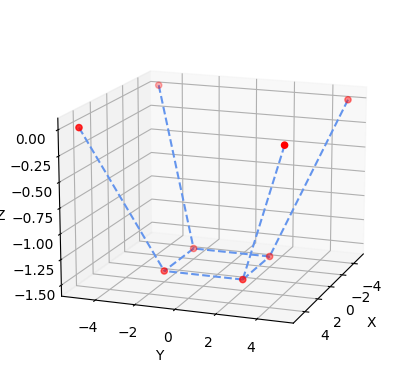

In [13]:
gRho = np.zeros(N)

ex1 = Initialization(E_tot,e_cable,e_bar,k,c,mg,gRho,N,M)
X1 = BFGS(X0,1,E_tot,gradient,ex1,tol=1e-8,c1=1e-3,c2=0.1)

plot_cables_bars(X1,e_cable,e_bar,savefigure = "P6")

## Fixed nodes, with bars

Example 1: No weight

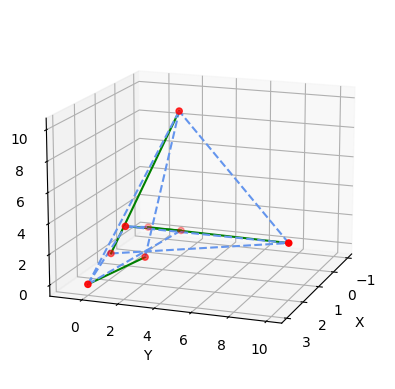

In [14]:
k = 0.1
c = 1   
M = 4

# Fixed nodes
p1 = [1, 1, 0]
p2 = [-1, 1, 0]
p3 = [-1, -1, 0]
p4 = [1, -1, 0]

# Free nodes
x5 = [3,0,0]
x6 = [2,1,3]
x7 = [2,10,3]
x8 = [1,3,10]

X0 = np.array((p1, p2, p3, p4, x5, x6, x7, x8), dtype=float)
N = len(X0)
mg = np.zeros(N)
gRho = 0

e = np.zeros((len(X0), len(X0)))
# Set the length to l_ij
e[0,7], e[1, 4], e[2,5], e[3,6], e[4, 5], e[5, 6], e[6, 7], e[7, 4] = 8,8,8,8,1,1,1,1
e_cable = e + e.T
e = np.zeros((len(X0), len(X0)))
e[0,4], e[1, 5], e[2,6], e[3,7] = 10,10,10,10
e_bar = e + e.T

plot_cables_bars(X0,e_cable,e_bar)

Grad norm at breaking: 2.752460886953588e-09
BFGS iterations: 97, X: 
[[ 1.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00 -1.00000000e+00  0.00000000e+00]
 [-7.09710334e-01  2.91554066e-08  9.54287111e+00]
 [ 2.99969499e-09 -7.09710229e-01  9.54287114e+00]
 [ 7.09710340e-01  1.84133276e-08  9.54287108e+00]
 [ 5.00441833e-10  7.09710271e-01  9.54287108e+00]])


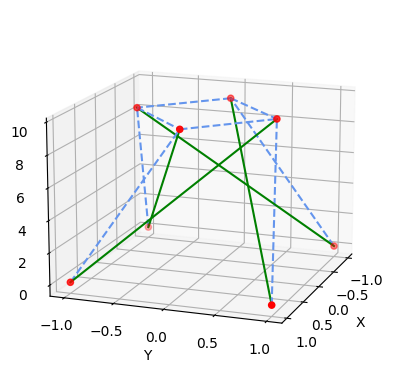

In [15]:
gRho = 0
mg[M:] = 0
k = 0.1
c = 1
ex2 = Initialization(E_tot,e_cable,e_bar,k,c,mg,gRho,N,M)
alpha0 = 1.0
X1 = BFGS(X0, alpha0, E_tot,gradient, ex2,tol=1e-8,c1=1e-3,c2=0.1)
plot_cables_bars(X1,e_cable,e_bar,savefigure="P10")

Example 2: Weights

Grad norm at breaking: 5.083596725997564e-09
BFGS iterations: 42, X: 
[[  1.           1.           0.        ]
 [ -1.           1.           0.        ]
 [ -1.          -1.           0.        ]
 [  1.          -1.           0.        ]
 [  0.37699006   0.60791981 -14.03660542]
 [ -0.60791979   0.37699009 -14.03660544]
 [ -0.37699014  -0.60791979 -14.03660543]
 [  0.60791972  -0.37699009 -14.03660549]])


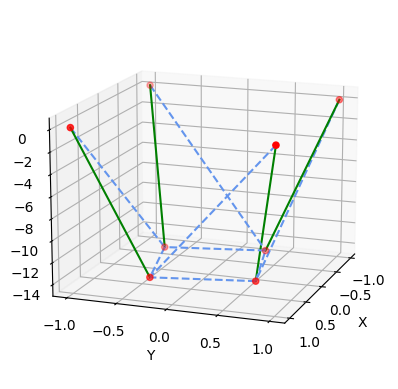

In [16]:
gRho = 0.01
mg[M:] = 0
k = 0.1
c= 1
ex2 = Initialization(E_tot,e_cable,e_bar,k,c,mg,gRho,N,M)
alpha0 = 1.0
X1 = BFGS(X0, alpha0, E_tot,gradient, ex2,tol=1e-8,c1=1e-3,c2=0.1)
plot_cables_bars(X1,e_cable,e_bar,savefigure="P10_2")

Example 3: Non-convex

Free node above ground:
Grad norm at breaking: 4.97494830815795e-10
BFGS iterations: 7, X: 
[[ 0.5         0.8660254   0.        ]
 [-0.5         0.8660254   0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.57735027  0.8114811 ]])


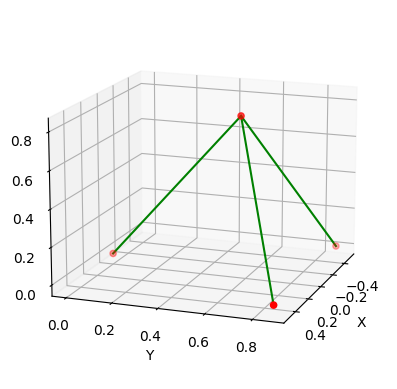

Total energy: 0.00813991435732562
Free node below ground:
Grad norm at breaking: 2.5107449021388974e-09
BFGS iterations: 7, X: 
[[ 0.5         0.8660254   0.        ]
 [-0.5         0.8660254   0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.57735027 -0.82148144]])


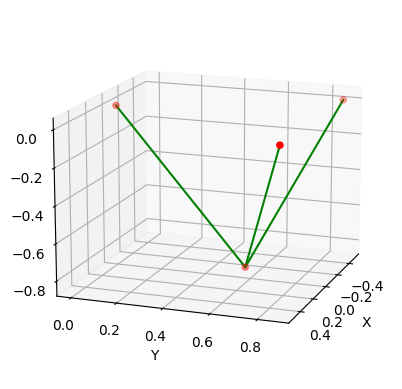

Total energy: -0.00818991519075619


In [17]:
k = 0.1
c = 1   
M = 3

# Fixed nodes
p1 = [1/2,3**0.5/2,  0]
p2 = [-1/2,3**0.5/2, 0]
p3 = [0, 0, 0]

# Free nodes
x5 = [0,0,1]


X0 = np.array((p1, p2, p3, x5), dtype=float)
N = len(X0)
mg = np.zeros(N)
gRho = 0

e = np.zeros((len(X0), len(X0)))
# Set the length to l_ij
e[0,3], e[1,3], e[2,3] = 0,0,0
e_cable = e + e.T
e = np.zeros((len(X0), len(X0)))
e[0,3], e[1,3], e[2,3] = 1,1,1
e_bar = e + e.T

gRho = 0
mg[M:] = 0.01
k = 0.1
c = 1
ex2 = Initialization(E_tot,e_cable,e_bar,k,c,mg,gRho,N,M)
alpha0 = 1.0
print("Free node above ground:")
X1 = BFGS(X0, alpha0, E_tot,gradient, ex2,tol=1e-8,c1=1e-3,c2=0.1)
plot_cables_bars(X1,e_cable,e_bar,savefigure="P9_1")
print("Total energy:", E_tot(X1,ex2))

print("Free node below ground:")
X0[3] = [0,0,-1]
X1 = BFGS(X0, alpha0, E_tot,gradient, ex2,tol=1e-8,c1=1e-3,c2=0.1)
plot_cables_bars(X1,e_cable,e_bar,savefigure="P9_2")
print("Total energy:",E_tot(X1,ex2))

Example 4: Assymetric, with weight

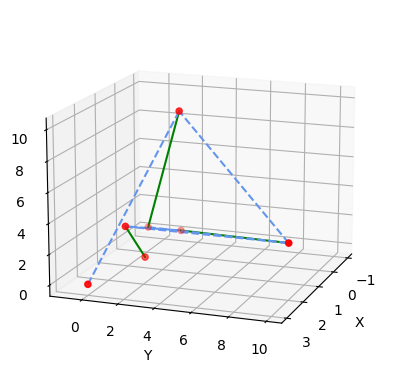

In [18]:
k = 0.1
c = 1   
M = 3

# Fixed nodes
p1 = [1, 1, 0]
p2 = [-1, 1, 0]
p3 = [-1, -1, 0]

# Free nodes
x4 = [3,0,0]
x5 = [2,1,3]
x6 = [2,10,3]
x7 = [1,3,10]

X0 = np.array((p1, p2, p3, x4, x5, x6, x7), dtype=float)
N = len(X0)
mg = np.zeros(N)
gRho = 0

e = np.zeros((len(X0), len(X0)))
# Set the length to l_ij
e[1, 4], e[2,5], e[3,6], e[4, 5], e[5, 6] = 8,8,8,1,1
e_cable = e + e.T
e = np.zeros((len(X0), len(X0)))
e[0,4], e[1, 5], e[2,6] = 10,10,10
e_bar = e + e.T
plot_cables_bars(X0,e_cable,e_bar)

Grad norm at breaking: 2.250528803620183e-08
BFGS iterations: 92, X: 
[[  1.           1.           0.        ]
 [ -1.           1.           0.        ]
 [ -1.          -1.           0.        ]
 [ -0.80406093  -0.22559388 -30.7417525 ]
 [  0.12956844   0.70206034 -14.9851577 ]
 [ -0.6901913    0.22437618 -15.3757785 ]
 [ -0.80405436  -0.22560988 -16.34175124]])


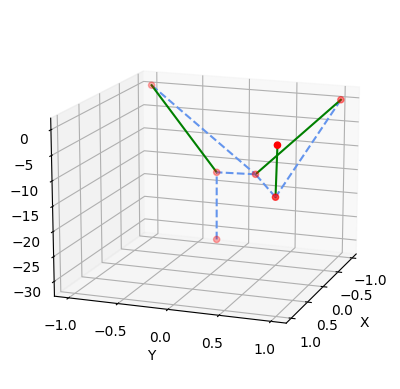

In [19]:
gRho = 0.01
mg[M:] = 0.01
k = 0.1
c= 1
ex2 = Initialization(E_tot,e_cable,e_bar,k,c,mg,gRho,N,M)
alpha0 = 1.0
X1 = BFGS(X0, alpha0, E_tot,gradient, ex2)
plot_cables_bars(X1,e_cable,e_bar,savefigure="P10_3")

Example 5: Above ground with weight

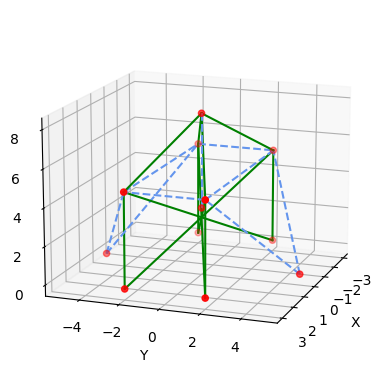

In [20]:
k = 0.1
c = 1
M = 6

# Fixed nodes
s = 3
t = 2
p1 = [s, t, 0]
p2 = [s, -t, 0]
p3 = [0, -5, 0]
p4 = [-s, -t, 0]
p5 = [-s, t, 0]
p6 = [0, 5, 0]

# Free nodes

x7 = [s, t, 5]
x8 = [s, -t, 5]
x9 = [-s, -t, 5]
x10 = [-s, t, 5]
x11 = [0, 0, 8]
x12 = [0,0,3]


X0 = np.array((p1, p2, p3, p4, p5, p6, x7,x8,x9,x10,x11,x12), dtype=float)
N = len(X0)
mg = np.zeros(N)
gRho = 0

e = np.zeros((len(X0), len(X0)))
# Set the length to l_ij
e[2, 7], e[2,8], e[5,6], e[5, 9],e[10,11] = 3,3,3,3,2
#e[0,7],e[1,6],e[3,9],e[4,8] = 4,4,4,4
e[6,7],e[7,8],e[8,9],e[6,9] = 3,5,3,5
e_cable = e + e.T
e = np.zeros((len(X0), len(X0)))
e[0,6], e[1, 7], e[3,8], e[4,9] = 8,8,8,8
e[6,10], e[7,10], e[8,10],e[9,10] = 6,6,6,6
e[1,9],e[0,8],e[3,6],e[4,7]=17,17,17,17

e_bar = e + e.T
plot_cables_bars(X0,e_cable,e_bar, savefigure="P10_5_init")

In [ ]:
gRho = 1e-4
mg[M:] = 0.01
k = 0.1
c= 1
ex2 = Initialization(E_tot,e_cable,e_bar,k,c,mg,gRho,N,M)
alpha0 = 1.0
X1 = BFGS(X0, alpha0, E_tot,gradient, ex2)
plot_cables_bars(X1,e_cable,e_bar,savefigure="P10_5")

Grad norm at breaking: 2.1630109637230007e-08
BFGS iterations: 18, X: 
[[ 3.00000000e+00  2.00000000e+00  0.00000000e+00]
 [ 3.00000000e+00 -2.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.00000000e+00  0.00000000e+00]
 [-3.00000000e+00 -2.00000000e+00  0.00000000e+00]
 [-3.00000000e+00  2.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  5.00000000e+00  0.00000000e+00]
 [ 2.63432665e+00  3.14169127e+00  5.59921243e+00]
 [ 2.63432665e+00 -3.14169127e+00  5.59921243e+00]
 [-2.63432665e+00 -3.14169127e+00  5.59921243e+00]
 [-2.63432665e+00  3.14169127e+00  5.59921243e+00]
 [-1.17636425e-15  1.60939625e-14  9.59737615e+00]
 [-7.86797654e-16 -1.08352082e-15  7.19737681e+00]])


## All node free nodes, with ground constraint

In [ ]:
def QuadPenalty(f,ci,gradient,c_gradient,x_init,obj,mu_k=10,tol = 1e-6,maxiter=5):
    x = x_init
    for j in range(maxiter):
        grad = lambda x,obj: gradient(x,obj) + mu_k*c_gradient(x,ci)
        
        f_eval = lambda x,obj: f(x,obj) + 0.5*mu_k*sum(max(-ci(x[i]),0)**2 for i in range(N))
        
        x = BFGS(x,1.0,f_eval,grad,obj,maxiter=500,tol=1e-5,c1=1e-3,c2=0.1)
        
        mu_k*=10
        
        if(np.linalg.norm(ci(x)) < tol):
            break
    return x

In [ ]:
def ci(x):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    return x3 - (x1**2 + x2**2)/20

def gradient_c(x,ci):
    grad = np.zeros((N,3))
    for i in range(len(x)):
        if ci(x[i]) < 0:
            x1 = x[i,0]
            x2 = x[i,1]
            grad[i] = np.array([-x1/10,-x2/10,1])*(ci(x[i]))
    return grad

In [ ]:
k = 0.1
c = 1 
M = 0

gRho = 1e-4
x1 = [1, 1, 0]
x2 = [-1, 1, 0]
x3 = [-1,-1, 0]
x4 = [1, -1, 0]
s = 0.7
t = 0.9
x5 = [-s,0,t]
x6 = [0,-s,t]
x7 = [s,0,t]
x8 = [0,s,t]

X0 = np.array((x1, x2, x3, x4, x5, x6, x7, x8), dtype=float)
N = len(X0)
mg = np.zeros(N)
lambda_init = np.zeros(N)


e = np.zeros((len(X0), len(X0)))
# Set the length to l_ij
e[0,7], e[1, 4], e[2,5], e[3,6], e[4, 5], e[5, 6], e[6, 7], e[7, 4]= 8,8,8,8,1,1,1,1
e[0,1], e[0,3], e[1,2], e[2,3] = 2,2,2,2
e_cable = e + e.T
e = np.zeros((len(X0), len(X0)))
e[0,4], e[1, 5], e[2,6], e[3,7] = 10,10,10,10
e_bar = e + e.T

In [ ]:
mg[0:] = 0
ex3 = Initialization(E_tot,e_cable,e_bar,k,c,mg,gRho,N,M)
X1 = QuadPenalty(E_tot,ci,gradient,gradient_c,X0,ex3,maxiter=5,mu_k = 10)

Grad norm at breaking: 7.638329678315731e-06
BFGS iterations: 51, X: 
[[-1.15321091 -0.83086153  9.51466794]
 [ 0.83088757 -1.15327261  9.51500796]
 [ 1.15323261  0.83085691  9.51480355]
 [-0.83086731  1.15323709  9.51477868]
 [ 0.70813891 -0.0477926   0.02508712]
 [ 0.04778771  0.70818556  0.02509077]
 [-0.70815696  0.04779789  0.02508813]
 [-0.04780121 -0.70816622  0.02508968]])
Grad norm at breaking: 4.6743217126381795e-06
BFGS iterations: 2, X: 
[[-1.15321091 -0.83086154  9.51466799]
 [ 0.83088757 -1.15327259  9.51500793]
 [ 1.15323261  0.83085689  9.51480356]
 [-0.83086731  1.15323709  9.5147787 ]
 [ 0.70813257 -0.04779215  0.02517677]
 [ 0.04778729  0.70817922  0.02518008]
 [-0.70815059  0.04779747  0.02517808]
 [-0.0478008  -0.70815993  0.02517875]])
Grad norm at breaking: 4.8892836451216956e-06
BFGS iterations: 2, X: 
[[-1.15321091 -0.83086154  9.51466799]
 [ 0.83088757 -1.15327259  9.51500792]
 [ 1.15323261  0.83085689  9.51480356]
 [-0.83086731  1.15323709  9.51477871]
 [ 0.7

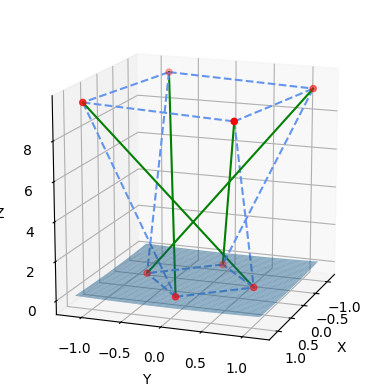

In [ ]:
plot_cables_bars(X1,e_cable,e_bar,savefigure="P12_1",ground=True)

Grad norm at breaking: 9.693299862081341e-06
BFGS iterations: 381, X: 
[[ 0.66427228  4.87024181  1.20797544]
 [ 1.70452835  4.61315189  1.20927885]
 [-0.28361527  4.90895028  1.2088619 ]
 [-1.34140015  4.73796818  1.21233487]
 [-0.2057502  -4.81106401  1.15938333]
 [-1.19886459 -4.66344145  1.15919823]
 [-0.20842269 -4.81106523  1.15943913]
 [ 0.79343521 -4.74495646  1.15715717]])
Grad norm at breaking: 2.255340548273918e-06
BFGS iterations: 2, X: 
[[ 0.66426987  4.87022408  1.20801186]
 [ 1.70452211  4.61313498  1.20931551]
 [-0.28361425  4.90893264  1.20889784]
 [-1.34139528  4.73795103  1.21237108]
 [-0.20574944 -4.81104638  1.15941999]
 [-1.19886022 -4.66342446  1.15923466]
 [-0.20842192 -4.81104754  1.1594759 ]
 [ 0.7934323  -4.74493898  1.15719402]])
Grad norm at breaking: 2.371070422714532e-06
BFGS iterations: 2, X: 
[[ 0.66426963  4.87022232  1.20801548]
 [ 1.7045215   4.61313331  1.20931912]
 [-0.28361414  4.90893086  1.20890146]
 [-1.3413948   4.73794932  1.21237469]
 [-0.20

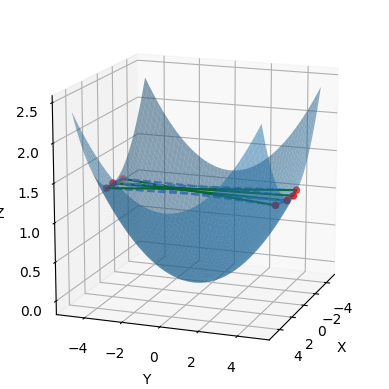

In [ ]:
X0[0] = [1,1,0.5]
X1 = QuadPenalty(E_tot,ci,gradient,gradient_c,X0,ex3,maxiter=5,mu_k = 10)
plot_cables_bars(X1,e_cable,e_bar,savefigure="P12_2",ground=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ee5611cf-05e8-4382-8cf5-16fd0627b5d6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>